# Gesture Recognition

In this project we are going to build a CNN based model, for smart TV, that will be able to predict 5 gestures correctly:

* Thumbs up:  Increase the volume
* Thumbs down: Decrease the volume
* Left swipe: 'Jump' backwards 10 seconds
* Right swipe: 'Jump' forward 10 seconds  
* Stop: Pause the movie

#### Importing necessary libraries

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import keras
import cv2
import matplotlib.pyplot as plt
import imageio

Using TensorFlow backend.


In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D, Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import keras

from keras.applications import mobilenet

#### Defining plotting function

In [4]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

#### Paths to the csv files (traing and validation). Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

In [5]:
train_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/val.csv').readlines())
batch_size = 20

### Defining generator function
This is one of the most important part of the code. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. Here, we need to experiment with img_idx, y,z and normalization such that we get high accuracy.

In [59]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [num for num in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    imgage_re = imresize(image,(120,120))
                    image_nor = imgage_re/255-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (imgage_re[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (imgage_re[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (imgage_re[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,len(img_idx),y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    imgage_re = imresize(image,(120,120))
                    image_nor = imgage_re/255-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (imgage_re[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (imgage_re[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (imgage_re[:,:,2]) #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [60]:
curr_dt_time = datetime.datetime.now()
train_path = '/notebooks/storage/Final_data/Collated_training/train'
val_path = '/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

In [61]:
train_generator = generator(train_path, train_doc, batch_size)

## Model Building

### Base Model: Model-1_Conv_3D

In [9]:
#write your model here
#model a
model_a = Sequential()

model_a.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(32, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(64, #Number pf filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(128, #Number pf filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
model_a.add(Flatten())

model_a.add(Dense(1000, activation='relu'))
model_a.add(Dropout(0.5))

model_a.add(Dense(500, activation='relu'))
model_a.add(Dropout(0.5))

#softmax layer
model_a.add(Dense(5, activation='softmax'))

In [10]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_a.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)
print(curr_dt_time)

# training sequences = 663
# validation sequences = 100
# epochs = 10
2020-03-01 17:11:19.105844


In [12]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
batch_size = 50
num_epochs = 10

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
model_a_history = model_a.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
model_a_history

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 50
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 50
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/34 [=========>....................] - ETA: 6:07 - loss: 1.7502 - categorical_accuracy: 0.3533Batch:  14 Index: 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 254s 7s/step - loss: 1.6201 - categorical_accuracy: 0.4094 - val_loss: 1.1956 - val_categorical_accuracy: 0.5120

Epoch 00001: saving model to model_init_2020-03-0117_11_19.105844/model-00001-1.67186-0.38245-1.19558-0.51200.h5
Epoch 2/10
34/34 [==============================] - 59s 2s/step - loss: 1.2915 - categorical_accuracy: 0.4774 - val_loss: 1.4707 - val_categorical_accuracy: 0.4280

Epoch 00002: saving model to model_init_2020-03-0117_11_19.105844/model-00002-1.29152-0.47738-1.47069-0.42800.h5
Epoch 3/10
34/34 [==============================] - 58s 2s/step - loss: 1.2637 - categorical_accuracy: 0.5023 - val_loss: 1.0014 - val_categorical_accuracy: 0.5760

Epoch 00003: saving model to model_init_2020-03-0117_11_19.105844/model-00003-1.26375-0.50226-1.00136-0.57600.h5
Epoch 4/10
34/34 [==============================] - 59s 2s/step - loss: 0.9927 - categorical_accuracy: 0.5792 - val_loss: 1.6463 - val_categorical_accuracy: 0.3600

Epoch 00004

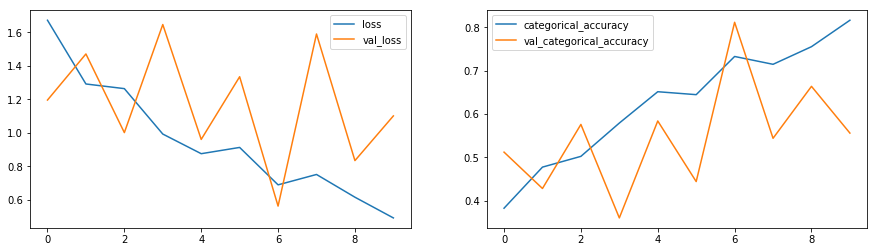

In [18]:
plot(model_a_history)

##### Conclusion:
* The current model with 1.8M parameters is doing great in training data but failed with validation data.
* Looks like the model is overfitting
* Let's tweak the neurons in the dense layer in the next model

### Model-2_Conv_3D

In [19]:
nb_filters = [8,16,32,64,128]
nb_dense = [256, 128, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model_b = Sequential()

model_b.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_b.add(BatchNormalization())
model_b.add(Activation('relu'))

model_b.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_b.add(BatchNormalization())
model_b.add(Activation('relu'))

model_b.add(MaxPooling3D(pool_size=(2,2,2)))

model_b.add(Conv3D(nb_filters[2], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_b.add(BatchNormalization())
model_b.add(Activation('relu'))


model_b.add(MaxPooling3D(pool_size=(2,2,2)))

model_b.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_b.add(BatchNormalization())
model_b.add(Activation('relu'))


model_b.add(MaxPooling3D(pool_size=(2,2,2)))

model_b.add(Conv3D(nb_filters[4], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_b.add(Activation('relu'))
model_b.add(Dropout(0.25))

model_b.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model_b.add(Flatten())

model_b.add(Dense(nb_dense[0], activation='relu'))
model_b.add(Dropout(0.5))

model_b.add(Dense(nb_dense[1], activation='relu'))
model_b.add(Dropout(0.5))

#softmax layer
model_b.add(Dense(nb_dense[2], activation='softmax'))

In [20]:
optimiser = keras.optimizers.Adam() #write your optimizer
model_b.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_b.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_6 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 30, 120, 120, 16)  3472      
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_7 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 15, 60, 60, 16)    0         
__________

In [21]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = num_epochs # choose the number of epochs
print ('# epochs =', num_epochs)
print(curr_dt_time)

# training sequences = 663
# validation sequences = 100
# epochs = 10
2020-03-01 17:28:28.858160


In [22]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
batch_size = 40
num_epochs = 30

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_b_history = model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
model_b_history

Source path =  /mnt/disks/user/project/PROJECT/Project_data/valSource path =  /mnt/disks/user/project/PROJECT/Project_data/train Epoch 1/30
 ; batch size = 40
; batch size = 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Batch:  3 Index: 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 79s 6s/step - loss: 2.5070 - categorical_accuracy: 0.2196 - val_loss: 1.5447 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2020-03-0117_28_28.858160/model-00001-2.50699-0.21964-1.54472-0.25000.h5
Epoch 2/30
14/14 [==============================] - 41s 3s/step - loss: 1.5541 - categorical_accuracy: 0.2432 - val_loss: 1.4388 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-03-0117_28_28.858160/model-00002-1.55619-0.24157-1.43881-0.25000.h5
Epoch 3/30
14/14 [==============================] - 36s 3s/step - loss: 1.4055 - categorical_accuracy: 0.3882 - val_loss: 1.9973 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2020-03-0117_28_28.858160/model-00003-1.40554-0.38820-1.99729-0.20000.h5
Epoch 4/30
14/14 [==============================] - 33s 2s/step - loss: 1.3524 - categorical_accuracy: 0.4034 - val_loss: 1.3525 - val_categorical_accuracy: 0.3750

Epoch 00004:

14/14 [==============================] - 29s 2s/step - loss: 0.9820 - categorical_accuracy: 0.5798 - val_loss: 0.9993 - val_categorical_accuracy: 0.6000

Epoch 00027: saving model to model_init_2020-03-0117_28_28.858160/model-00027-0.98198-0.57983-0.99925-0.60000.h5
Epoch 28/30
14/14 [==============================] - 29s 2s/step - loss: 1.0554 - categorical_accuracy: 0.5168 - val_loss: 0.9275 - val_categorical_accuracy: 0.6250

Epoch 00028: saving model to model_init_2020-03-0117_28_28.858160/model-00028-1.05541-0.51681-0.92754-0.62500.h5

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 29/30
14/14 [==============================] - 30s 2s/step - loss: 1.0039 - categorical_accuracy: 0.5462 - val_loss: 0.9975 - val_categorical_accuracy: 0.6000

Epoch 00029: saving model to model_init_2020-03-0117_28_28.858160/model-00029-1.00386-0.54622-0.99745-0.60000.h5
Epoch 30/30
14/14 [==============================] - 30s 2s/step - loss: 1.0258 - categorical_

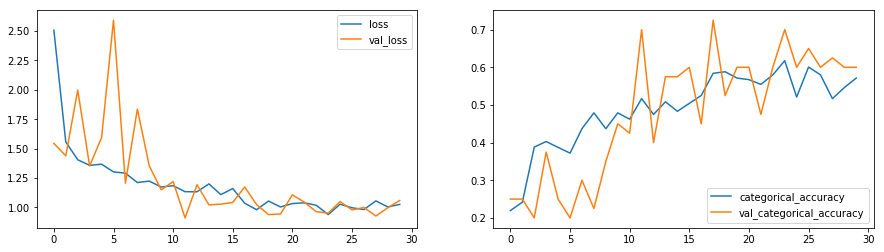

In [25]:
plot(model_b_history)

#### Conclusion:
* Network train and test accuracies are 57 and 60 respectively. The network is not learning much. let's try another network with some adjustmets.
* now in the next network increase the number of fileters

### Model-3_Conv_3D

In [10]:
nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model_c = Sequential()

model_c.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_c.add(BatchNormalization())
model_c.add(Activation('relu'))

model_c.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_c.add(BatchNormalization())
model_c.add(Activation('relu'))

model_c.add(MaxPooling3D(pool_size=(2,2,2)))

model_c.add(Conv3D(nb_filters[2], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_c.add(BatchNormalization())
model_c.add(Activation('relu'))


model_c.add(MaxPooling3D(pool_size=(3,3,3)))

model_c.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_c.add(BatchNormalization())
model_c.add(Activation('relu'))
model_c.add(Dropout(0.25))

model_c.add(MaxPooling3D(pool_size=(1,3,3)))



#Flatten Layers
model_c.add(Flatten())

model_c.add(Dense(nb_dense[0], activation='relu'))
model_c.add(Dropout(0.5))

model_c.add(Dense(nb_dense[1], activation='relu'))
model_c.add(Dropout(0.5))

#softmax layer
model_c.add(Dense(nb_dense[2], activation='softmax'))

In [11]:
optimiser = keras.optimizers.Adam() #write your optimizer
model_c.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_c.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 120, 120, 16)  3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
__________

In [18]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
print(curr_dt_time)

# training sequences = 663
# validation sequences = 100
# epochs = 20
2020-03-01 19:19:53.191428


In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
batch_size = 30
num_epochs = 20
model_c_history = model_c.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
model_c_history

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 20
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 20
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 5s - loss: 10.7227 - categorical_accuracy: 0.2313Batch:  34 Index: 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 95s 3s/step - loss: 10.6031 - categorical_accuracy: 0.2421 - val_loss: 8.0869 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to model_init_2020-03-0119_08_38.010258/model-00001-10.59954-0.23982-8.08685-0.34000.h5
Epoch 2/20
34/34 [==============================] - 15s 448ms/step - loss: 10.4303 - categorical_accuracy: 0.2745 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_init_2020-03-0119_08_38.010258/model-00002-10.43030-0.27451-13.53920-0.16000.h5
Epoch 3/20
34/34 [==============================] - 15s 447ms/step - loss: 12.8015 - categorical_accuracy: 0.1863 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2020-03-0119_08_38.010258/model-00003-12.80148-0.18627-13.53920-0.16000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
34/34 [==============================] - 17s 490ms/step - loss: 12.66

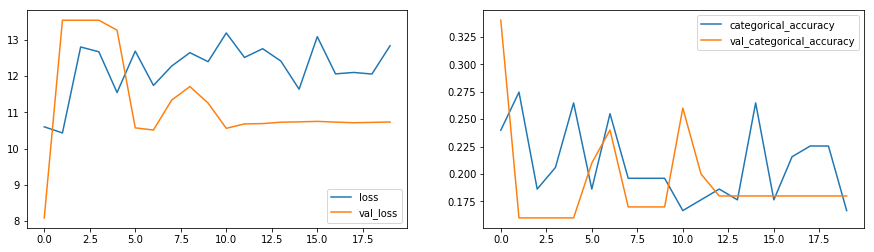

In [17]:
plot(model_c_history)

#### Conclusion:
* Network accuracy is not going well, Lets Try some other network by increasing the number of filters to 32,64,128 and 256

### Model-4_Conv_3D

In [34]:
nb_filters = [32,64,128,256]
nb_dense = [256, 128, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model_d = Sequential()

model_d.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_d.add(BatchNormalization())
model_d.add(Activation('relu'))

model_d.add(MaxPooling3D(pool_size=(2,2,2)))

model_d.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_d.add(BatchNormalization())
model_d.add(Activation('relu'))


model_d.add(MaxPooling3D(pool_size=(2,2,2)))

model_d.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_d.add(BatchNormalization())
model_d.add(Activation('relu'))


model_d.add(MaxPooling3D(pool_size=(2,2,2)))

model_d.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_d.add(Activation('relu'))
model_d.add(Dropout(0.25))

model_d.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model_d.add(Flatten())

model_d.add(Dense(nb_dense[0], activation='relu'))
model_d.add(Dropout(0.5))

model_d.add(Dense(nb_dense[1], activation='relu'))
model_d.add(Dropout(0.5))

#softmax layer
model_d.add(Dense(nb_dense[2], activation='softmax'))

In [41]:
optimiser = keras.optimizers.Adam() #write your optimizer
model_d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization_14 (Batc (None, 30, 120, 120, 32)  128       
_________________________________________________________________
activation_15 (Activation)   (None, 30, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 15, 60, 60, 64)    55360     
_________________________________________________________________
batch_normalization_15 (Batc (None, 15, 60, 60, 64)    256       
_________________________________________________________________
activation_16 (Activation)   (None, 15, 60, 60, 64)    0         
__________

In [42]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = num_epochs # choose the number of epochs
print ('# epochs =', num_epochs)
print(curr_dt_time)

# training sequences = 663
# validation sequences = 100
# epochs = 30
2020-03-01 17:55:41.130584


In [43]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [44]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [49]:
batch_size = 20
num_epochs = 30
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [50]:
model_d_history = model_d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
model_d_history

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 20
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 20
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 43s 3s/step - loss: 3.1211 - categorical_accuracy: 0.2071 - val_loss: 1.6055 - val_categorical_accuracy: 0.1750

Epoch 00001: saving model to model_init_2020-03-0117_55_41.130584/model-00001-3.12115-0.20714-1.60546-0.17500.h5
Epoch 2/30
14/14 [==============================] - 32s 2s/step - loss: 1.5290 - categorical_accuracy: 0.2750 - val_loss: 2.2803 - val_categorical_accuracy: 0.2250

Epoch 00002: saving model to model_init_2020-03-0117_55_41.130584/model-00002-1.52897-0.27500-2.28030-0.22500.h5
Epoch 3/30
 4/14 [=======>......................] - ETA: 22s - loss: 1.4143 - categorical_accuracy: 0.3250Batch:  34 Index: 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 16s 1s/step - loss: 1.6242 - categorical_accuracy: 0.3016 - val_loss: 1.5479 - val_categorical_accuracy: 0.2250

Epoch 00003: saving model to model_init_2020-03-0117_55_41.130584/model-00003-1.52994-0.30709-1.54793-0.22500.h5
Epoch 4/30
14/14 [==============================] - 5s 343ms/step - loss: 1.5794 - categorical_accuracy: 0.3571 - val_loss: 1.9559 - val_categorical_accuracy: 0.2000

Epoch 00004: saving model to model_init_2020-03-0117_55_41.130584/model-00004-1.57935-0.35714-1.95593-0.20000.h5
Epoch 5/30
14/14 [==============================] - 5s 373ms/step - loss: 1.7047 - categorical_accuracy: 0.1190 - val_loss: 1.4920 - val_categorical_accuracy: 0.2250

Epoch 00005: saving model to model_init_2020-03-0117_55_41.130584/model-00005-1.70468-0.11905-1.49202-0.22500.h5
Epoch 6/30
14/14 [==============================] - 7s 484ms/step - loss: 1.5637 - categorical_accuracy: 0.2857 - val_loss: 1.9319 - val_categorical_accuracy: 0.1500

Epoch 

14/14 [==============================] - 7s 501ms/step - loss: 1.6223 - categorical_accuracy: 0.2381 - val_loss: 1.6177 - val_categorical_accuracy: 0.2000

Epoch 00030: saving model to model_init_2020-03-0117_55_41.130584/model-00030-1.62231-0.23810-1.61774-0.20000.h5


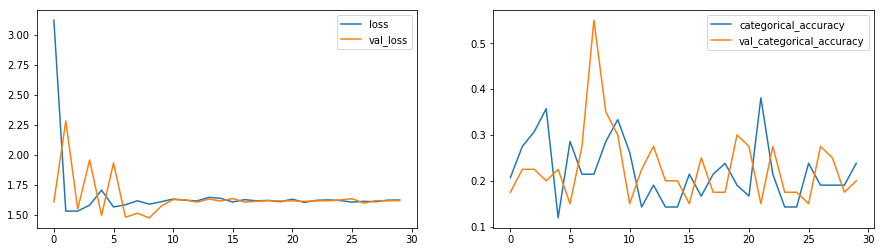

In [51]:
plot(model_d_history)

#### Conclusion:
* Still not good in terms of accuracy, and model is not consistenly learning, lets try some other netwrok by slightly reducing the numbers of filters in each layer. Now lets start with 16 filters and then 32,62 & 128 res.

### Model-5_Conv_3D

In [52]:
nb_filters = [16,32,64,128]
nb_dense = [256, 128, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model_e = Sequential()

model_e.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_e.add(BatchNormalization())
model_e.add(Activation('relu'))

model_e.add(MaxPooling3D(pool_size=(2,2,2)))

model_e.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_e.add(BatchNormalization())
model_e.add(Activation('relu'))


model_e.add(MaxPooling3D(pool_size=(2,2,2)))

model_e.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_e.add(BatchNormalization())
model_e.add(Activation('relu'))


model_e.add(MaxPooling3D(pool_size=(2,2,2)))

model_e.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_e.add(Activation('relu'))
model_e.add(Dropout(0.25))

model_e.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model_e.add(Flatten())

model_e.add(Dense(nb_dense[0], activation='relu'))
model_e.add(Dropout(0.5))

model_e.add(Dense(nb_dense[1], activation='relu'))
model_e.add(Dropout(0.5))

#softmax layer
model_e.add(Dense(nb_dense[2], activation='softmax'))

In [54]:
optimiser = keras.optimizers.Adam() #write your optimizer
model_e.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_e.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_17 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_19 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_18 (Batc (None, 15, 60, 60, 32)    128       
_________________________________________________________________
activation_20 (Activation)   (None, 15, 60, 60, 32)    0         
__________

In [55]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = num_epochs # choose the number of epochs
print ('# epochs =', num_epochs)
print(curr_dt_time)

# training sequences = 663
# validation sequences = 100
# epochs = 30
2020-03-01 18:04:12.920011


In [56]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [57]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [58]:
batch_size = 50
num_epochs = 30
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [59]:
model_e_history = model_e.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
model_e_history

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 50
Source path =  Epoch 1/30
/mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/34 [=========>....................] - ETA: 2:37 - loss: 2.4645 - categorical_accuracy: 0.2317Batch:  14 Index: 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 127s 4s/step - loss: 1.9028 - categorical_accuracy: 0.2247 - val_loss: 1.5085 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-03-0118_04_12.920011/model-00001-2.15699-0.22860-1.50853-0.44000.h5
Epoch 2/30
34/34 [==============================] - 59s 2s/step - loss: 1.4312 - categorical_accuracy: 0.3733 - val_loss: 1.7878 - val_categorical_accuracy: 0.2080

Epoch 00002: saving model to model_init_2020-03-0118_04_12.920011/model-00002-1.43124-0.37330-1.78780-0.20800.h5
Epoch 3/30
34/34 [==============================] - 60s 2s/step - loss: 1.3265 - categorical_accuracy: 0.4276 - val_loss: 1.0706 - val_categorical_accuracy: 0.5960

Epoch 00003: saving model to model_init_2020-03-0118_04_12.920011/model-00003-1.32647-0.42760-1.07059-0.59600.h5
Epoch 4/30
34/34 [==============================] - 62s 2s/step - loss: 1.2765 - categorical_accuracy: 0.4796 - val_loss: 1.1964 - val_categorical_accuracy: 0.5720

Epoch 00004


Epoch 00028: saving model to model_init_2020-03-0118_04_12.920011/model-00028-0.29746-0.88688-0.37362-0.86400.h5
Epoch 29/30
34/34 [==============================] - 60s 2s/step - loss: 0.3428 - categorical_accuracy: 0.8643 - val_loss: 0.3825 - val_categorical_accuracy: 0.8520

Epoch 00029: saving model to model_init_2020-03-0118_04_12.920011/model-00029-0.34282-0.86425-0.38249-0.85200.h5
Epoch 30/30
34/34 [==============================] - 59s 2s/step - loss: 0.3002 - categorical_accuracy: 0.9005 - val_loss: 0.3798 - val_categorical_accuracy: 0.8480

Epoch 00030: saving model to model_init_2020-03-0118_04_12.920011/model-00030-0.30022-0.90045-0.37984-0.84800.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.


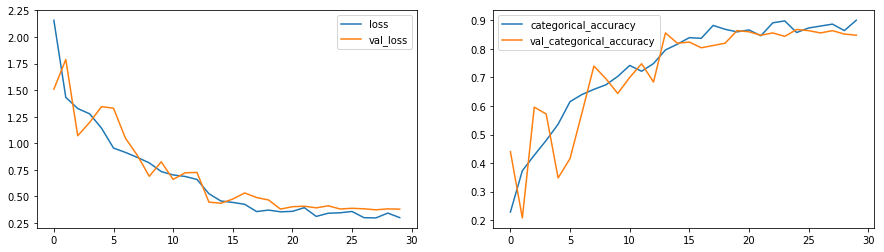

In [60]:
plot(model_e_history)

#### Conclusion:
* this one looks good train accuracy is at 78 and test is at 82, giving better results. Lets exploare some options to increase the accuracy.
* we will keep the filters as is, but lets increase the neurons in dense layers and see how it results

### Model-6_Conv_3D

In [22]:
nb_filters = [8,16,32,64]
nb_dense = [512, 256, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model_f = Sequential()

model_f.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_f.add(BatchNormalization())
model_f.add(Activation('relu'))

model_f.add(MaxPooling3D(pool_size=(2,2,2)))

model_f.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_f.add(BatchNormalization())
model_f.add(Activation('relu'))


model_f.add(MaxPooling3D(pool_size=(2,2,2)))

model_f.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_f.add(BatchNormalization())
model_f.add(Activation('relu'))


model_f.add(MaxPooling3D(pool_size=(2,2,2)))

model_f.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_f.add(Activation('relu'))
model_f.add(Dropout(0.25))

model_f.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model_f.add(Flatten())

model_f.add(Dense(nb_dense[0], activation='relu'))
model_f.add(Dropout(0.5))

model_f.add(Dense(nb_dense[1], activation='relu'))
model_f.add(Dropout(0.5))

#softmax layer
model_f.add(Dense(nb_dense[2], activation='softmax'))

In [23]:
optimiser = keras.optimizers.Adam() #write your optimizer
model_f.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_f.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 16)    0         
__________

In [24]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = num_epochs # choose the number of epochs
print ('# epochs =', num_epochs)
print(curr_dt_time)

# training sequences = 663
# validation sequences = 100
# epochs = 20
2020-03-01 19:20:25.758805


In [25]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [27]:
batch_size = 50
num_epochs = 30
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [28]:
model_f_history = model_f.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
model_f_history

Source path = Source path = Epoch 1/30
 /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 50
 /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/23 [==============>...............] - ETA: 1:17 - loss: 2.4941 - categorical_accuracy: 0.2350Batch:  14 Index: 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 108s 5s/step - loss: 2.0105 - categorical_accuracy: 0.2992 - val_loss: 1.3521 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2020-03-0119_20_25.758805/model-00001-2.25734-0.26795-1.35211-0.33000.h5
Epoch 2/30
23/23 [==============================] - 41s 2s/step - loss: 1.3474 - categorical_accuracy: 0.3946 - val_loss: 1.6704 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_init_2020-03-0119_20_25.758805/model-00002-1.34742-0.39465-1.67036-0.26000.h5
Epoch 3/30
23/23 [==============================] - 42s 2s/step - loss: 1.3285 - categorical_accuracy: 0.4181 - val_loss: 1.2135 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_2020-03-0119_20_25.758805/model-00003-1.32846-0.41806-1.21351-0.49000.h5
Epoch 4/30
23/23 [==============================] - 42s 2s/step - loss: 1.2213 - categorical_accuracy: 0.4716 - val_loss: 1.2275 - val_categorical_accuracy: 0.4000

Epoch 00004

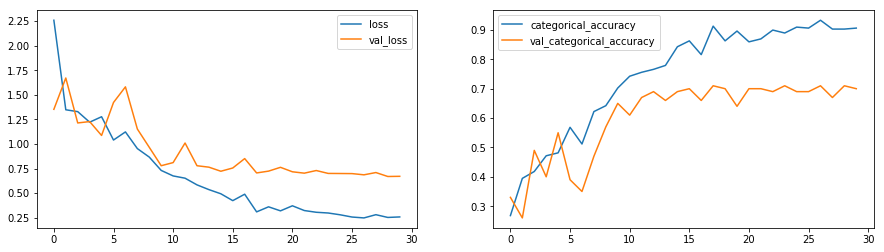

In [29]:
plot(model_f_history)

#### Conclusion:
* train and test accuracies are very close to each other but over all test accuraccies are not more than 0.74, let's try some other models.
* In the next model we will keep all the parameters same except max pooling layer's pool size after last CONV 3d layer, we will increase it to (3,3,3) from (2,2,2)

### Model-7_Conv_3D

In [70]:
nb_filters = [16,32,64,128]
nb_dense = [512, 256, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model_g = Sequential()

model_g.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_g.add(BatchNormalization())
model_g.add(Activation('relu'))

model_g.add(MaxPooling3D(pool_size=(2,2,2)))

model_g.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_g.add(BatchNormalization())
model_g.add(Activation('relu'))


model_g.add(MaxPooling3D(pool_size=(2,2,2)))

model_g.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_g.add(BatchNormalization())
model_g.add(Activation('relu'))


model_g.add(MaxPooling3D(pool_size=(2,2,2)))

model_g.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_g.add(Activation('relu'))
model_g.add(Dropout(0.25))

model_g.add(MaxPooling3D(pool_size=(3,3,3)))


#Flatten Layers
model_g.add(Flatten())

model_g.add(Dense(nb_dense[0], activation='relu'))
model_g.add(Dropout(0.5))

model_g.add(Dense(nb_dense[1], activation='relu'))
model_g.add(Dropout(0.5))

#softmax layer
model_g.add(Dense(nb_dense[2], activation='softmax'))

In [72]:
optimiser = keras.optimizers.Adam() #write your optimizer
model_g.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_g.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_29 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_30 (Batc (None, 15, 60, 60, 32)    128       
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 32)    0         
__________

In [73]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = num_epochs # choose the number of epochs
print ('# epochs =', num_epochs)
print(curr_dt_time)

# training sequences = 663
# validation sequences = 100
# epochs = 30
2020-03-02 16:40:26.869932


In [74]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [75]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [76]:
batch_size = 50
num_epochs = 30
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [77]:
model_g_history = model_g.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
model_g_history

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 50
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = Epoch 1/30
50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/14 [========================>.....] - ETA: 14s - loss: 2.6045 - categorical_accuracy: 0.2650Batch:  14 Index: 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 95s 7s/step - loss: 2.4506 - categorical_accuracy: 0.2661 - val_loss: 1.4506 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2020-03-0216_40_26.869932/model-00001-2.50207-0.26395-1.45059-0.24000.h5
Epoch 2/30
14/14 [==============================] - 17s 1s/step - loss: 1.4344 - categorical_accuracy: 0.3297 - val_loss: 1.3372 - val_categorical_accuracy: 0.3600

Epoch 00002: saving model to model_init_2020-03-0216_40_26.869932/model-00002-1.43441-0.32967-1.33719-0.36000.h5
Epoch 3/30
14/14 [==============================] - 25s 2s/step - loss: 1.3262 - categorical_accuracy: 0.4341 - val_loss: 1.8588 - val_categorical_accuracy: 0.2800

Epoch 00003: saving model to model_init_2020-03-0216_40_26.869932/model-00003-1.32622-0.43407-1.85880-0.28000.h5
Epoch 4/30
14/14 [==============================] - 25s 2s/step - loss: 1.3008 - categorical_accuracy: 0.4286 - val_loss: 1.1537 - val_categorical_accuracy: 0.4100

Epoch 00004:

14/14 [==============================] - 25s 2s/step - loss: 0.6592 - categorical_accuracy: 0.7308 - val_loss: 0.7039 - val_categorical_accuracy: 0.7300

Epoch 00029: saving model to model_init_2020-03-0216_40_26.869932/model-00029-0.65919-0.73077-0.70394-0.73000.h5
Epoch 30/30
14/14 [==============================] - 24s 2s/step - loss: 0.5965 - categorical_accuracy: 0.7747 - val_loss: 0.7028 - val_categorical_accuracy: 0.7300

Epoch 00030: saving model to model_init_2020-03-0216_40_26.869932/model-00030-0.59652-0.77473-0.70281-0.73000.h5


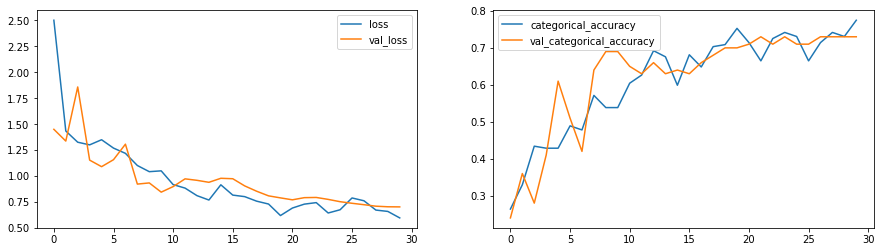

In [78]:
plot(model_g_history)

#### Conclusion:
* This one looks good with train accuracy 87 and test accuracy is 79. but still model over fits and total number of paramets used are 1.8m . Lets explore some more options and find the optimal value for parameters.
* we will decease the nuerons in dense layers back to 256 ,128 and 5. as more number of nuerons in dense layer is leading to overfitting.

### Model-8_Conv_3D

In [62]:
nb_filters = [16,32,64,128]
nb_dense = [256, 128, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model_h = Sequential()

model_h.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_h.add(BatchNormalization())
model_h.add(Activation('relu'))

model_h.add(MaxPooling3D(pool_size=(2,2,2)))

model_h.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_h.add(BatchNormalization())
model_h.add(Activation('relu'))


model_h.add(MaxPooling3D(pool_size=(2,2,2)))

model_h.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_h.add(BatchNormalization())
model_h.add(Activation('relu'))


model_h.add(MaxPooling3D(pool_size=(2,2,2)))

model_h.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_h.add(Activation('relu'))
model_h.add(Dropout(0.25))

model_h.add(MaxPooling3D(pool_size=(3,3,3)))


#Flatten Layers
model_h.add(Flatten())

model_h.add(Dense(nb_dense[0], activation='relu'))
model_h.add(Dropout(0.5))

model_h.add(Dense(nb_dense[1], activation='relu'))
model_h.add(Dropout(0.5))

#softmax layer
model_h.add(Dense(nb_dense[2], activation='softmax'))

In [63]:
optimiser = keras.optimizers.Adam() #write your optimizer
model_h.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_h.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_26 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_27 (Batc (None, 15, 60, 60, 32)    128       
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
__________

In [64]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = num_epochs # choose the number of epochs
print ('# epochs =', num_epochs)
print(curr_dt_time)

# training sequences = 663
# validation sequences = 100
# epochs = 20
2020-03-02 16:07:15.482864


In [65]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [66]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [67]:
batch_size = 50
num_epochs = 30
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [68]:
model_h_history = model_h.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
model_h_history

Source path = Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 50
 /mnt/disks/user/project/PROJECT/Project_data/val Epoch 1/30
; batch size = 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/34 [=========>....................] - ETA: 2:38 - loss: 2.5680 - categorical_accuracy: 0.2217Batch:  14 Index: 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 127s 4s/step - loss: 1.9317 - categorical_accuracy: 0.2740 - val_loss: 1.5444 - val_categorical_accuracy: 0.3120

Epoch 00001: saving model to model_init_2020-03-0216_07_15.482864/model-00001-2.22115-0.24702-1.54440-0.31200.h5
Epoch 2/30
34/34 [==============================] - 54s 2s/step - loss: 1.4708 - categorical_accuracy: 0.3529 - val_loss: 1.2393 - val_categorical_accuracy: 0.5040

Epoch 00002: saving model to model_init_2020-03-0216_07_15.482864/model-00002-1.47077-0.35294-1.23925-0.50400.h5
Epoch 3/30
34/34 [==============================] - 59s 2s/step - loss: 1.3975 - categorical_accuracy: 0.3824 - val_loss: 1.9556 - val_categorical_accuracy: 0.2440

Epoch 00003: saving model to model_init_2020-03-0216_07_15.482864/model-00003-1.39753-0.38235-1.95564-0.24400.h5
Epoch 4/30
34/34 [==============================] - 59s 2s/step - loss: 1.2592 - categorical_accuracy: 0.4729 - val_loss: 1.1290 - val_categorical_accuracy: 0.4880

Epoch 00004

34/34 [==============================] - 60s 2s/step - loss: 0.2858 - categorical_accuracy: 0.8891 - val_loss: 0.4940 - val_categorical_accuracy: 0.8200

Epoch 00029: saving model to model_init_2020-03-0216_07_15.482864/model-00029-0.28581-0.88914-0.49405-0.82000.h5
Epoch 30/30
34/34 [==============================] - 58s 2s/step - loss: 0.3135 - categorical_accuracy: 0.8756 - val_loss: 0.4836 - val_categorical_accuracy: 0.8160

Epoch 00030: saving model to model_init_2020-03-0216_07_15.482864/model-00030-0.31351-0.87557-0.48357-0.81600.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


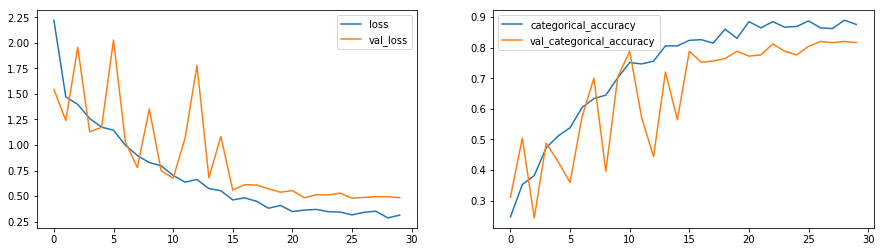

In [69]:
plot(model_h_history)

#### Conclusion:
* This model is the best one we got so far with train accuracy 91 and test accuracy 83. with total number of parameters used is .96 M, among the Conv 3d Models this looks as the best interms of accuracy as well as the size of the model. This one is our final model in 3d CNNs, now lets move on and try CNN_RNN

## CNN-RNN Architecture

In [6]:
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_feed=30
batch_size=50
num_epochs=20
skip = 1

In [7]:
def generator(source_path, folder_list, augment = False):
    img_idx = [num for num in range(0,total_frames, skip) ]#np.round(np.linspace(0, total_frames - 1, frames_to_sample)).astype(int)
    #batch_size = batch_size
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        
        for batch in range(num_batches): 
            batch_data, batch_labels= single_batch(source_path, t, batch, batch_size, img_idx, augment)
            yield batch_data, batch_labels 

        remaining_seq = len(t)%batch_size
        
        if (remaining_seq != 0):
            batch_data, batch_labels = single_batch(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
            yield batch_data, batch_labels

In [8]:
def single_batch(source_path, t, batch, batch_size, img_idx, augment, remaining_seq = 0):
    
        len_seq = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((len_seq, len(img_idx), image_height, image_width, channels)) 
        batch_labels = np.zeros((len_seq, num_classes)) 
    
        if (augment): batch_aug = np.zeros((len_seq, len(img_idx), image_height, image_width, channels))
        
        for folder in range(len_seq): 
            pics = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) #imgs = pics
            for idx,item in enumerate(img_idx): 
                image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+pics[item]).astype(np.float32)
                image_resized = imresize(image,(image_height, image_width, 3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(image_height, image_width, 3))
                    
                    Im = cv2.getRotationMatrix2D((image_width//2, image_height//2), np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, Im, (image_width, image_height))
            
                    batch_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        if (augment):
            batch_data = np.concatenate([batch_data, batch_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        
        return(batch_data,batch_labels)

In [9]:
train_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/val.csv').readlines())
train_path = '/mnt/disks/user/project/PROJECT/Project_data' + '/' + 'train'
val_path =  '/mnt/disks/user/project/PROJECT/Project_data' + '/' + 'val'
num_train_seq = len(train_doc)#num_train_sequences = len(train_doc)
num_val_seq = len(val_doc)

### Base Model: Model-1_CNNRNN

In [10]:
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_feed=30
batch_size=50
num_epochs=20
skip = 1

model_1_cnnrnn = Sequential()

model_1_cnnrnn.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), 
                          input_shape=(frames_feed, image_height, image_width, channels)))
model_1_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_1_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_1_cnnrnn.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_1_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_1_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_1_cnnrnn.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_1_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_1_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_1_cnnrnn.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_1_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_1_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_1_cnnrnn.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_1_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_1_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))

model_1_cnnrnn.add(TimeDistributed(Flatten()))

model_1_cnnrnn.add(LSTM(128))
model_1_cnnrnn.add(Dropout(0.25))
        
model_1_cnnrnn.add(Dense(128, activation='relu'))
model_1_cnnrnn.add(Dropout(0.25))
        
model_1_cnnrnn.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam()
model_1_cnnrnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_1_cnnrnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 30, 30, 64)    18496     
__________

In [11]:
train_generator = generator(train_path, train_doc, augment = False)
val_generator = generator(val_path, val_doc)

In [12]:
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

In [13]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [14]:
if (num_train_seq%batch_size) == 0:
    steps_per_epoch = int(num_train_seq/batch_size)
else:
    steps_per_epoch = (num_train_seq//batch_size) + 1

if (num_val_seq%batch_size) == 0:
    validation_steps = int(num_val_seq/batch_size)
else:
    validation_steps = (num_val_seq//batch_size) + 1

In [15]:
num_epochs=20
model_1_cnnrnn_history = model_1_cnnrnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                      callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, 
                      class_weight=None, workers=1, initial_epoch=0)
model_1_cnnrnn_history

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


14/14 [==============================] - 242s 17s/step - loss: 1.5324 - categorical_accuracy: 0.3306 - val_loss: 1.5874 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2020-03-0214_05_09.358564/model-00001-1.52767-0.33183-1.58739-0.30000.h5
Epoch 2/20
14/14 [==============================] - 80s 6s/step - loss: 1.2885 - categorical_accuracy: 0.4529 - val_loss: 1.5683 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_init_2020-03-0214_05_09.358564/model-00002-1.29309-0.45249-1.56825-0.26000.h5
Epoch 3/20
14/14 [==============================] - 82s 6s/step - loss: 1.1099 - categorical_accuracy: 0.5666 - val_loss: 1.5650 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to model_init_2020-03-0214_05_09.358564/model-00003-1.12420-0.56410-1.56501-0.30000.h5
Epoch 4/20
14/14 [==============================] - 82s 6s/step - loss: 1.0442 - categorical_accuracy: 0.5820 - val_loss: 1.2149 - val_categorical_accuracy: 0.5500

Epoch 0000

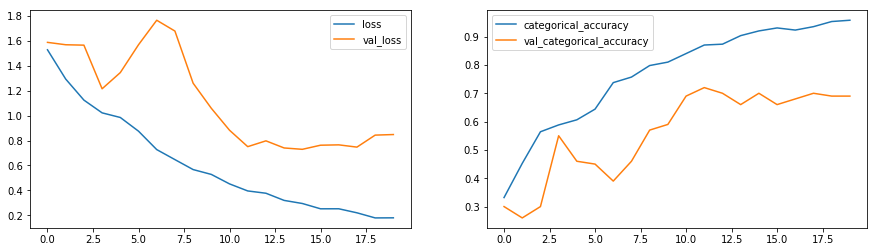

In [16]:
plot(model_1_cnnrnn_history)

#### Conclusion:
* Takes longer time (in the next model 15 images are fed to reduce time)
* Val_accuracy is much lower than than the training accuracy

#### Model-2_CNNRNN
Feeding 15 imges, otherwise same as Model-1_CNNRNN

In [17]:
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_feed=15
batch_size=50
num_epochs=20
skip = 2

model_2_cnnrnn = Sequential()

model_2_cnnrnn.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), 
                          input_shape=(frames_feed, image_height, image_width, channels)))
model_2_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_2_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_2_cnnrnn.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_2_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_2_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_2_cnnrnn.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_2_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_2_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_2_cnnrnn.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_2_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_2_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_2_cnnrnn.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_2_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_2_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))

model_2_cnnrnn.add(TimeDistributed(Flatten()))

model_2_cnnrnn.add(LSTM(128))
model_2_cnnrnn.add(Dropout(0.25))
        
model_2_cnnrnn.add(Dense(128, activation='relu'))
model_2_cnnrnn.add(Dropout(0.25))
        
model_2_cnnrnn.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam()
model_2_cnnrnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_2_cnnrnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 15, 30, 30, 64)    18496     
__________

In [18]:
train_generator = generator(train_path, train_doc, augment = False)
val_generator = generator(val_path, val_doc)

In [19]:
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

In [20]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [21]:
if (num_train_seq%batch_size) == 0:
    steps_per_epoch = int(num_train_seq/batch_size)
else:
    steps_per_epoch = (num_train_seq//batch_size) + 1

if (num_val_seq%batch_size) == 0:
    validation_steps = int(num_val_seq/batch_size)
else:
    validation_steps = (num_val_seq//batch_size) + 1

In [22]:
num_epochs=20
model_2_cnnrnn_history = model_2_cnnrnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                      callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, 
                      class_weight=None, workers=1, initial_epoch=0)
model_2_cnnrnn_history

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


14/14 [==============================] - 51s 4s/step - loss: 1.5493 - categorical_accuracy: 0.2810 - val_loss: 1.3621 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-03-0214_35_23.303595/model-00001-1.54211-0.28356-1.36209-0.44000.h5
Epoch 2/20
14/14 [==============================] - 39s 3s/step - loss: 1.2741 - categorical_accuracy: 0.4634 - val_loss: 1.5921 - val_categorical_accuracy: 0.2700

Epoch 00002: saving model to model_init_2020-03-0214_35_23.303595/model-00002-1.27686-0.45551-1.59206-0.27000.h5
Epoch 3/20
14/14 [==============================] - 42s 3s/step - loss: 1.1308 - categorical_accuracy: 0.5404 - val_loss: 1.2070 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-03-0214_35_23.303595/model-00003-1.12354-0.54449-1.20697-0.50000.h5
Epoch 4/20
14/14 [==============================] - 41s 3s/step - loss: 0.9860 - categorical_accuracy: 0.6068 - val_loss: 1.1257 - val_categorical_accuracy: 0.5800

Epoch 00004:

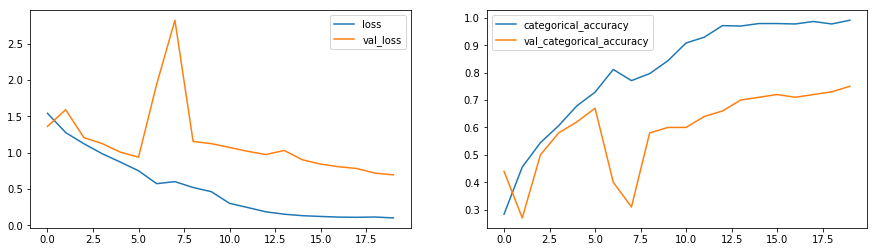

In [23]:
plot(model_2_cnnrnn_history)

#### Conclusion:
Training accuracy has gone up to 0.98 but validation accuracy is only 0.73. Looks like the model suffers from overfitting. We need much simpler model. Let's try GRU, instead of LSTM

#### Model-3_CNNRNN
With GRU, otherwise like Model-2_CNNRNN

In [24]:
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_feed=15
batch_size=50
num_epochs=20
skip = 2

model_3_cnnrnn = Sequential()

model_3_cnnrnn.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), 
                          input_shape=(frames_feed, image_height, image_width, channels)))
model_3_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_3_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_3_cnnrnn.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_3_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_3_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_3_cnnrnn.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_3_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_3_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_3_cnnrnn.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_3_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_3_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_3_cnnrnn.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_3_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_3_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))

model_3_cnnrnn.add(TimeDistributed(Flatten()))

model_3_cnnrnn.add(GRU(128))
model_3_cnnrnn.add(Dropout(0.25))
        
model_3_cnnrnn.add(Dense(128, activation='relu'))
model_3_cnnrnn.add(Dropout(0.25))
        
model_3_cnnrnn.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam()
model_3_cnnrnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_3_cnnrnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_34 (TimeDis (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_35 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_37 (TimeDis (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 15, 30, 30, 64)    18496     
__________

In [25]:
train_generator = generator(train_path, train_doc, augment = False)
val_generator = generator(val_path, val_doc)

In [26]:
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

In [27]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [28]:
if (num_train_seq%batch_size) == 0:
    steps_per_epoch = int(num_train_seq/batch_size)
else:
    steps_per_epoch = (num_train_seq//batch_size) + 1

if (num_val_seq%batch_size) == 0:
    validation_steps = int(num_val_seq/batch_size)
else:
    validation_steps = (num_val_seq//batch_size) + 1

In [29]:
num_epochs=20
model_3_cnnrnn_history = model_3_cnnrnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                      callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, 
                      class_weight=None, workers=1, initial_epoch=0)
model_3_cnnrnn_history

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


14/14 [==============================] - 50s 4s/step - loss: 1.4761 - categorical_accuracy: 0.3550 - val_loss: 1.2512 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2020-03-0214_49_24.642894/model-00001-1.47539-0.35747-1.25123-0.45000.h5
Epoch 2/20
14/14 [==============================] - 39s 3s/step - loss: 1.1311 - categorical_accuracy: 0.5317 - val_loss: 1.0568 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2020-03-0214_49_24.642894/model-00002-1.14224-0.52338-1.05675-0.61000.h5
Epoch 3/20
14/14 [==============================] - 41s 3s/step - loss: 0.9845 - categorical_accuracy: 0.6054 - val_loss: 0.9604 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_2020-03-0214_49_24.642894/model-00003-0.98316-0.61689-0.96043-0.60000.h5
Epoch 4/20
14/14 [==============================] - 41s 3s/step - loss: 0.8544 - categorical_accuracy: 0.6803 - val_loss: 0.8915 - val_categorical_accuracy: 0.6600

Epoch 00004:

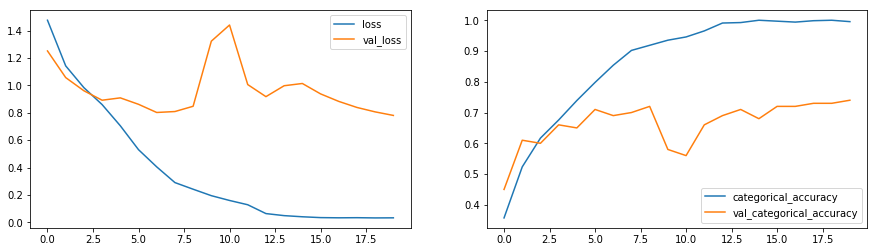

In [30]:
plot(model_3_cnnrnn_history)

#### Conclusion:
With GRU also we have overfitted model

#### Model-4_CNNRNN
With lesser layers, otherwise like Model-3_CNNRNN

In [31]:
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_feed=15
batch_size=50
num_epochs=20
skip = 2

model_4_cnnrnn = Sequential()

model_4_cnnrnn.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), 
                          input_shape=(frames_feed, image_height, image_width, channels)))
model_4_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_4_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_4_cnnrnn.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_4_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_4_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_4_cnnrnn.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_4_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_4_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_4_cnnrnn.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_4_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_4_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4_cnnrnn.add(TimeDistributed(Flatten()))

model_4_cnnrnn.add(GRU(128))
model_4_cnnrnn.add(Dropout(0.25))
        
model_4_cnnrnn.add(Dense(128, activation='relu'))
model_4_cnnrnn.add(Dropout(0.25))
        
model_4_cnnrnn.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam()
model_4_cnnrnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_4_cnnrnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_49 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_50 (TimeDis (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_51 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_52 (TimeDis (None, 15, 60, 60, 64)    9280      
_________________________________________________________________
time_distributed_53 (TimeDis (None, 15, 60, 60, 64)    256       
_________________________________________________________________
time_distributed_54 (TimeDis (None, 15, 30, 30, 64)    0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, 15, 30, 30, 128)   73856     
__________

In [32]:
train_generator = generator(train_path, train_doc, augment = False)
val_generator = generator(val_path, val_doc)

In [33]:
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

In [34]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [35]:
if (num_train_seq%batch_size) == 0:
    steps_per_epoch = int(num_train_seq/batch_size)
else:
    steps_per_epoch = (num_train_seq//batch_size) + 1

if (num_val_seq%batch_size) == 0:
    validation_steps = int(num_val_seq/batch_size)
else:
    validation_steps = (num_val_seq//batch_size) + 1

In [36]:
num_epochs=20
model_4_cnnrnn_history = model_4_cnnrnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                      callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, 
                      class_weight=None, workers=1, initial_epoch=0)
model_4_cnnrnn_history

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


14/14 [==============================] - 53s 4s/step - loss: 1.6078 - categorical_accuracy: 0.3225 - val_loss: 1.3455 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-03-0215_03_26.658689/model-00001-1.60374-0.32730-1.34548-0.44000.h5
Epoch 2/20
14/14 [==============================] - 39s 3s/step - loss: 1.2871 - categorical_accuracy: 0.4524 - val_loss: 1.3183 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-03-0215_03_26.658689/model-00002-1.29330-0.44796-1.31827-0.50000.h5
Epoch 3/20
14/14 [==============================] - 41s 3s/step - loss: 1.1217 - categorical_accuracy: 0.5466 - val_loss: 1.0604 - val_categorical_accuracy: 0.5300

Epoch 00003: saving model to model_init_2020-03-0215_03_26.658689/model-00003-1.11866-0.55505-1.06039-0.53000.h5
Epoch 4/20
14/14 [==============================] - 41s 3s/step - loss: 1.0506 - categorical_accuracy: 0.5730 - val_loss: 1.0504 - val_categorical_accuracy: 0.5800

Epoch 00004:

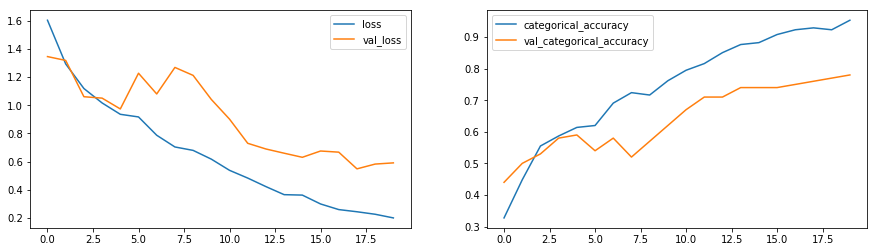

In [37]:
plot(model_4_cnnrnn_history)

#### Conclusion:
The issue of overfitting in Model-3_CNNRNN is not resolved in Model-4_CNNRNN

#### Model-5_CNNRNN
With more dropouts, otherwise like Model-4_CNNRNN

In [38]:
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_feed=15
batch_size=50
num_epochs=20
skip = 2

model_5_cnnrnn = Sequential()

model_5_cnnrnn.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), 
                          input_shape=(frames_feed, image_height, image_width, channels)))
model_5_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_5_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_5_cnnrnn.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_5_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_5_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_5_cnnrnn.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_5_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_5_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_5_cnnrnn.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_5_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_5_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))

model_5_cnnrnn.add(TimeDistributed(Flatten()))

model_5_cnnrnn.add(GRU(128))
model_5_cnnrnn.add(Dropout(0.50))
        
model_5_cnnrnn.add(Dense(128, activation='relu'))
model_5_cnnrnn.add(Dropout(0.50))
        
model_5_cnnrnn.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam()
model_5_cnnrnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_5_cnnrnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_62 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_63 (TimeDis (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_64 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_65 (TimeDis (None, 15, 60, 60, 64)    9280      
_________________________________________________________________
time_distributed_66 (TimeDis (None, 15, 60, 60, 64)    256       
_________________________________________________________________
time_distributed_67 (TimeDis (None, 15, 30, 30, 64)    0         
_________________________________________________________________
time_distributed_68 (TimeDis (None, 15, 30, 30, 128)   73856     
__________

In [39]:
train_generator = generator(train_path, train_doc, augment = False)
val_generator = generator(val_path, val_doc)

In [40]:
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

In [41]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [42]:
if (num_train_seq%batch_size) == 0:
    steps_per_epoch = int(num_train_seq/batch_size)
else:
    steps_per_epoch = (num_train_seq//batch_size) + 1

if (num_val_seq%batch_size) == 0:
    validation_steps = int(num_val_seq/batch_size)
else:
    validation_steps = (num_val_seq//batch_size) + 1

In [43]:
num_epochs=20
model_5_cnnrnn_history = model_5_cnnrnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                      callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, 
                      class_weight=None, workers=1, initial_epoch=0)
model_5_cnnrnn_history

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


14/14 [==============================] - 52s 4s/step - loss: 1.8697 - categorical_accuracy: 0.2470 - val_loss: 1.5396 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2020-03-0215_17_36.906539/model-00001-1.86301-0.25189-1.53960-0.29000.h5
Epoch 2/20
14/14 [==============================] - 40s 3s/step - loss: 1.6342 - categorical_accuracy: 0.3134 - val_loss: 1.4700 - val_categorical_accuracy: 0.4100

Epoch 00002: saving model to model_init_2020-03-0215_17_36.906539/model-00002-1.62186-0.31373-1.47000-0.41000.h5
Epoch 3/20
14/14 [==============================] - 41s 3s/step - loss: 1.4931 - categorical_accuracy: 0.3426 - val_loss: 1.3786 - val_categorical_accuracy: 0.4600

Epoch 00003: saving model to model_init_2020-03-0215_17_36.906539/model-00003-1.49763-0.34842-1.37861-0.46000.h5
Epoch 4/20
14/14 [==============================] - 41s 3s/step - loss: 1.4409 - categorical_accuracy: 0.3823 - val_loss: 1.2674 - val_categorical_accuracy: 0.4800

Epoch 00004:

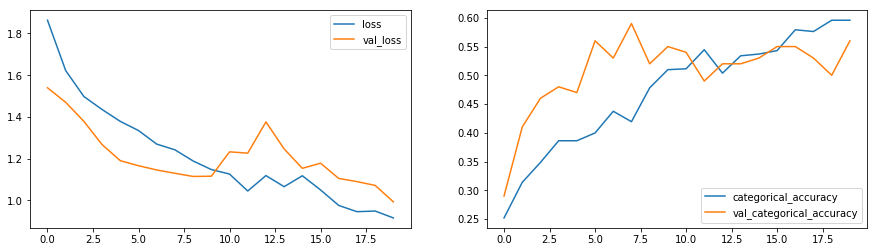

In [44]:
plot(model_5_cnnrnn_history)

#### Conclusion:
Now the model is not learning much

### Transfer Learning

#### Model-6_CNNRNN
Lets try transfer learning with LSTM first

In [45]:
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_feed=15
batch_size=20
num_epochs=20
skip = 2

mobilenet_transfer = mobilenet.MobileNet(weights = 'imagenet', include_top=False)
        
model_6_cnnrnn = Sequential()
model_6_cnnrnn.add(TimeDistributed(mobilenet_transfer, input_shape=(frames_feed, image_height,image_width,channels)))
 
model_6_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_6_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
model_6_cnnrnn.add(TimeDistributed(Flatten()))

model_6_cnnrnn.add(LSTM(128))
model_6_cnnrnn.add(Dropout(0.25))
        
model_6_cnnrnn.add(Dense(128, activation='relu'))
model_6_cnnrnn.add(Dropout(0.25))
        
model_6_cnnrnn.add(Dense(num_classes, activation='softmax'))
        
optimiser = optimizers.Adam()
model_6_cnnrnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_6_cnnrnn.summary())

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_75 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_76 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_77 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_78 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (D

In [46]:
train_generator = generator(train_path, train_doc, augment = False)
val_generator = generator(val_path, val_doc)

In [47]:
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

In [48]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [49]:
if (num_train_seq%batch_size) == 0:
    steps_per_epoch = int(num_train_seq/batch_size)
else:
    steps_per_epoch = (num_train_seq//batch_size) + 1

if (num_val_seq%batch_size) == 0:
    validation_steps = int(num_val_seq/batch_size)
else:
    validation_steps = (num_val_seq//batch_size) + 1

In [50]:
num_epochs=20
model_6_cnnrnn_history = model_6_cnnrnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                      callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, 
                      class_weight=None, workers=1, initial_epoch=0)
model_6_cnnrnn_history

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


34/34 [==============================] - 56s 2s/step - loss: 1.3115 - categorical_accuracy: 0.4687 - val_loss: 1.0083 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_init_2020-03-0215_32_01.875325/model-00001-1.28796-0.47210-1.00829-0.60000.h5
Epoch 2/20
34/34 [==============================] - 38s 1s/step - loss: 0.7641 - categorical_accuracy: 0.7042 - val_loss: 0.8543 - val_categorical_accuracy: 0.6700

Epoch 00002: saving model to model_init_2020-03-0215_32_01.875325/model-00002-0.77725-0.69683-0.85432-0.67000.h5
Epoch 3/20
34/34 [==============================] - 41s 1s/step - loss: 0.4185 - categorical_accuracy: 0.8484 - val_loss: 0.3993 - val_categorical_accuracy: 0.8400

Epoch 00003: saving model to model_init_2020-03-0215_32_01.875325/model-00003-0.40971-0.86124-0.39931-0.84000.h5
Epoch 4/20
34/34 [==============================] - 44s 1s/step - loss: 0.3364 - categorical_accuracy: 0.8859 - val_loss: 0.4016 - val_categorical_accuracy: 0.8400

Epoch 00004:

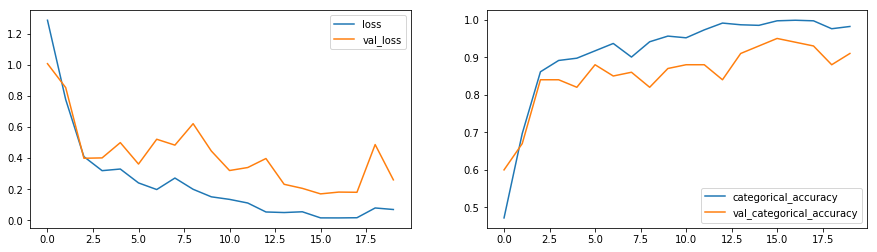

In [51]:
plot(model_6_cnnrnn_history)

#### Model-7_CNNRNN
transfer learning with GRU

In [52]:
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_feed=15
batch_size=20
num_epochs=20
skip = 2

mobilenet_transfer = mobilenet.MobileNet(weights = 'imagenet', include_top=False)
        
model_7_cnnrnn = Sequential()
model_7_cnnrnn.add(TimeDistributed(mobilenet_transfer, input_shape=(frames_feed, image_height,image_width,channels)))
 
model_7_cnnrnn.add(TimeDistributed(BatchNormalization()))
model_7_cnnrnn.add(TimeDistributed(MaxPooling2D((2, 2))))
model_7_cnnrnn.add(TimeDistributed(Flatten()))

model_7_cnnrnn.add(GRU(128))
model_7_cnnrnn.add(Dropout(0.25))
        
model_7_cnnrnn.add(Dense(128, activation='relu'))
model_7_cnnrnn.add(Dropout(0.25))
        
model_7_cnnrnn.add(Dense(num_classes, activation='softmax'))
        
optimiser = optimizers.Adam()
model_7_cnnrnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_7_cnnrnn.summary())

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_79 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_80 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_81 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_82 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
__________

In [53]:
train_generator = generator(train_path, train_doc, augment = False)
val_generator = generator(val_path, val_doc)

In [54]:
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

In [55]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [56]:
if (num_train_seq%batch_size) == 0:
    steps_per_epoch = int(num_train_seq/batch_size)
else:
    steps_per_epoch = (num_train_seq//batch_size) + 1

if (num_val_seq%batch_size) == 0:
    validation_steps = int(num_val_seq/batch_size)
else:
    validation_steps = (num_val_seq//batch_size) + 1

In [57]:
num_epochs=20
model_7_cnnrnn_history = model_7_cnnrnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                      callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, 
                      class_weight=None, workers=1, initial_epoch=0)
model_7_cnnrnn_history

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


34/34 [==============================] - 52s 2s/step - loss: 1.2837 - categorical_accuracy: 0.4577 - val_loss: 0.8849 - val_categorical_accuracy: 0.6200

Epoch 00001: saving model to model_init_2020-03-0215_47_06.290314/model-00001-1.29470-0.45249-0.88494-0.62000.h5
Epoch 2/20
34/34 [==============================] - 38s 1s/step - loss: 0.5674 - categorical_accuracy: 0.7815 - val_loss: 0.4933 - val_categorical_accuracy: 0.8100

Epoch 00002: saving model to model_init_2020-03-0215_47_06.290314/model-00002-0.54812-0.78431-0.49335-0.81000.h5
Epoch 3/20
34/34 [==============================] - 44s 1s/step - loss: 0.3451 - categorical_accuracy: 0.8874 - val_loss: 0.4423 - val_categorical_accuracy: 0.8400

Epoch 00003: saving model to model_init_2020-03-0215_47_06.290314/model-00003-0.33249-0.89291-0.44228-0.84000.h5
Epoch 4/20
34/34 [==============================] - 43s 1s/step - loss: 0.2114 - categorical_accuracy: 0.9279 - val_loss: 0.3316 - val_categorical_accuracy: 0.9000

Epoch 00004:

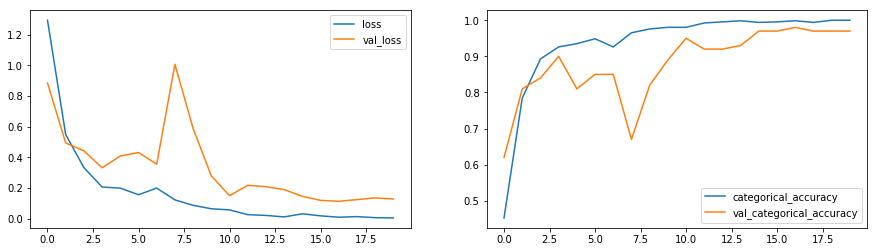

In [58]:
plot(model_7_cnnrnn_history)